In [2]:
import pathlib
import glob
import json

import dawg
import tqdm
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

results = {}
for file in tqdm.tqdm(list(pathlib.Path('VoxEL').glob('*.tsv'))):
    lang = file.stem
    index = glob.glob(f'../wiki/{lang}wiki-*/index_{lang}wiki-*.dawg')[0]
    wm = dawg.IntDAWG().load(index)
    
    cache = {}
    def predict(sent, surface, wm):
        ref = cache.setdefault(surface, wm.get( surface.replace(' ','_') ))
        return ref or -1

    surface, pred, gold = zip(*[
        (surface, predict(text, surface, wm), ref)
        for _, links, text in (l.split('\t') for l in file.open())
        for surface, ref in json.loads(links).items()
    ])

    res = pd.DataFrame({
        avg: precision_recall_fscore_support(gold, pred, zero_division=0, average=avg)[:-1]
        for avg in ['micro','macro']
    }, index=['precision', 'recall', 'fscore']).unstack().T
    res.loc[('', 'support')] = len(gold)
    results[lang] = res

(pd.DataFrame(results).T.sort_values(('','support'))[::-1]
 .style.bar(vmin=0, vmax=1, color='lightblue').format('{:.2f}')
 .set_caption('Wikipedia Page Name Baseline')
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Annotation problems

In [3]:
import pandas as pd
disambig = set(pd.read_csv('../data/wikidata-20211122-disambig.txt', header=None)[0])
listpage = set(pd.read_csv('../data/wikidata-20211122-list.txt', header=None)[0])

counts = {}
for file in tqdm.tqdm(list(pathlib.Path('VoxEL').glob('*.tsv'))):
    lang = file.stem
    refs = [
        ref
        for _, links, text in (l.split('\t') for l in file.open())
        for surface, ref in json.loads(links).items()
    ]
    
    counts[lang] = {
        'disambig': sum(1 for r in refs if r in disambig),
        'listpage': sum(1 for r in refs if r in listpage),
        'total': len(refs),
    }
pd.DataFrame(counts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2183.85it/s]


,en,de,fr,it,es
disambig,0,34,26,28,16
listpage,0,0,0,0,0
total,145,123,139,122,128


# Rank analysis

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]


<AxesSubplot:>

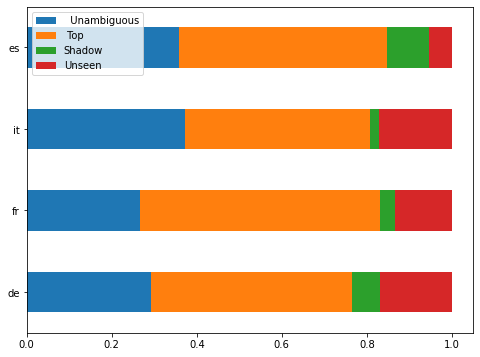

In [4]:
import json, re, html, pathlib
from collections import Counter

def normalize(a):
    QUOTECHARS = '\'\"〞「❜❞＂”‚〝»‟―‹›❛❮’‘〟❯„‛“❝«'
    if a:
        a = a.replace('_',' ')
        a = re.sub(f'[{QUOTECHARS}]', '', a.replace('&nbsp;', ' '))
        a = html.unescape(a).lower().strip().split(' (')[0]
        # no numbers or dates
        if not (a.startswith('<') or re.match('^[0-9-/—]+$', a)): 
            if a:
                yield a

def rank(wm, counts, surface, i):
    for norm in normalize(surface):
        norm = norm.lower()
        ent_count = counts.get(norm, {})
        if len(ent_count) == 1:
            return ent_count['Q%s'%i], -1
        if ent_count.get('Q%s'%i):
            order = sorted(ent_count, key=lambda x: -ent_count[x])
            return ent_count['Q%s'%i], order.index('Q%s'%i)
    if wm.get(surface.replace(' ','_')) == i:
        return 1, -1
    return 0, None

total_counts = {}
ranks = {}
for file in tqdm.tqdm(list(pathlib.Path('VoxEL').glob('*.tsv'))):
    lang = file.stem
    index = glob.glob(f'../wiki/{lang}wiki-*/index_{lang}wiki-*.dawg')[0]
    wm = dawg.IntDAWG().load(index)
    
    countfile = pathlib.Path(index).parent / 'count.min5.json'
    if not countfile.exists():
        continue            
    
    counts = json.load(open(countfile))
    
    total_counts[lang] = Counter()
    for ec in counts.values():
        for e,c in ec.items():
            total_counts[lang][int(e.replace('Q',''))] += c
    
    ranks[lang] = pd.DataFrame([
        (surface, ref, *rank(wm, counts, surface, ref))
        for _, links, text in (l.split('\t') for l in file.open())
        for surface, ref in json.loads(links).items()
        if ref not in disambig
    ], columns=['surface', 'ref', 'count', 'rank'])
    

pd.DataFrame({
    l:r['rank'].apply(lambda x: 'Unseen' if pd.isna(x) else ('Shadow' if x>0 else (' Top' if x==0 else '  Unambiguous'))).value_counts() / len(r)
    for l,r in ranks.items()
}).sort_index().T.plot.barh(stacked=True, figsize=(8,6))

In [5]:
# Unseen
ranks['it'][ranks['it']['count'] == 0]['surface'].value_counts().head(10)

Europa          6
Siria           2
Mediterraneo    2
Tsipras         2
Tusk            2
europei         1
Van Rompuy      1
Name: surface, dtype: int64

In [12]:
# Shadow
ranks['de'][ranks['de']['rank'] > 0]

,surface,ref,count,rank
15,Cameron,192,13,3.0
33,Syrien,207118,166,1.0
40,Österreich,783436,10,52.0
54,ISIS,2429253,91,2.0
57,Syrien,207118,166,1.0
67,Washington,61,2935,1.0


<AxesSubplot:>

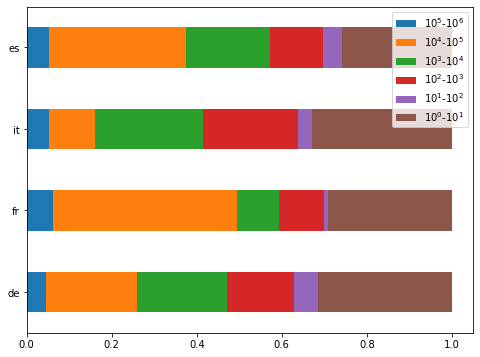

In [102]:
from numpy import log10
def freq_bins(l, r):
    return (
        r.merge(pd.Series(total_counts[l]).rename('total'), left_on='ref', right_index=True, how='left')['total'].fillna(1)
        .apply(lambda x: f'$10^{int(log10(x))}$-$10^{int(log10(x)+1)}$').value_counts()
    )
pd.DataFrame({
    l:freq_bins(l, r) / len(r)
    for l,r in ranks.items()
})[::-1].T.plot.barh(stacked=True, figsize=(8,6))